In [1]:
import gc
import os
from os.path import exists
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../input/lish-moa/train_features.csv')
test = pd.read_csv('../input/lish-moa/test_features.csv')
y_train = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
df = pd.concat([train, test], axis=0)
df = pd.merge(df, y_train, on=['sig_id'], how='left').fillna(-1)
cs_c = ["#c3c", "#3cc", "#cc3", "#777"]
del train, test
gc.collect()

0

In [3]:
i_feats = ['sig_id']
x_feats = ['cp_type', 'cp_time', 'cp_dose']
g_feats = [f'g-{i}' for i in range(772)]
c_feats = [f'c-{i}' for i in range(100)]
labels = y_train.columns.values[1:].tolist()
histbins = np.arange(-10, 10.5, .5)

In [4]:
cp_time = [24,48,72]
cp_dose = ['D1', 'D2']
cp_type = ["trt_cp", "ctl_vehicle"]

統計量を追加

In [5]:
stats_feats = ['c_mean', 'c_med', 'c_max', 'c_min']
for ch, feats in zip(['c', 'g'], [c_feats, g_feats]):
    df[f'{ch}_mean'] = df[feats].mean(axis=1)
    df[f'{ch}_std'] = df[feats].std(axis=1)
    df[f'{ch}_med'] = df[feats].median(axis=1)
    df[f'{ch}_max'] = df[feats].max(axis=1)
    df[f'{ch}_argmax'] = df[feats].idxmax(axis="columns")
    df[f'{ch}_min'] = df[feats].min(axis=1)
    df[f'{ch}_argmin'] = df[feats].idxmin(axis="columns")
    df[f'{ch}_skew'] = df[feats].skew(axis=1)

`trt_cp`のみに限定してラベル別に分割

In [6]:
def split_by_label(df, label):
    pos = df[df[label] == 1].copy()
    pos = pos[pos['cp_type']=='trt_cp'].copy()
    neg = df[df[label] == 0].copy()
    neg = neg[neg['cp_type']=='trt_cp'].copy()
    unk = df[df[label] == -1].copy()
    unk = unk[unk['cp_type']=='trt_cp'].copy()
    return pos, neg, unk

---
# シフトを探そう！

## ラベルごとに、各C特徴で相関を比較

In [18]:
def pos_neg_hist(pos, neg, unk, colname, colset, feats, suffix=""):
    if len(feats) > 10:
        res = len(feats) % 10
        if res != 0:
            feats = feats + feats[:(10-res)]
        feats_ = np.array(feats).reshape((-1,10))
    else: 
        feats_ = [feats]
    
    for batch_idx, feats_batch in enumerate(feats_):
        num_c = len(feats_batch)
        num_s = len(colset)
        fig, axes = plt.subplots(num_c, num_s, figsize=(5,10), sharex=True, sharey=True)
        fig.suptitle(f"pos(magenta) vs neg(cyan) vs unknown(gray)\nLabel:{label}")
        for j, ci in enumerate(feats_batch):
            print(f'batch {batch_idx:>3} / {len(feats_)}, plotting {j:>3} / {num_c:>3}', end='\r')
            for i, t in enumerate(colset):
                neg[neg[colname] == t][ci].hist(ax=axes[j][i], label="negative", color=cs_c[1], histtype='step', linewidth=.5, bins=histbins, density=True)
                unk[unk[colname] == t][ci].hist(ax=axes[j][i], label="unknown", color=cs_c[3], histtype='step', linewidth=.5, bins=histbins, density=True)
                pos[pos[colname] == t][ci].hist(ax=axes[j][i], label="positive", color=cs_c[0], histtype='step', linewidth=.5, bins=histbins, density=True)
                axes[j][i].grid(True)
            axes[j][0].set_ylabel(ci)
        for i, t in enumerate(colset):
            axes[0][i].set_title(f'{colname}:{t}')
            axes[0][i].set_xlim(-10,10)
            
        dir_ = f"image/pos-neg/{label}/by_{colname}_{suffix}"
        if not exists(dir_):
            os.makedirs(dir_)
        plt.savefig(f"{dir_}/{feats_batch[0]}.pdf")
        plt.close()
    print()

In [30]:
label = labels[0]
pos, neg, unk = split_by_label(df, label)

## cp_timeごとのc特徴

In [8]:
pos_neg_hist(pos, neg, unk, 'cp_time', cp_time, c_feats)

batch  77 / 78, plotting   9 /  10


## cp_doseごとのc特徴

In [9]:
pos_neg_hist(pos, neg, unk, 'cp_dose', cp_dose, c_feats)

batch  77 / 78, plotting   9 /  10


## cp_dose条件下で、cp_timeごとのc特徴

In [10]:
pos_neg_hist(pos[pos['cp_dose']=='D1'], 
             neg[neg['cp_dose']=='D1'], 
             unk[unk['cp_dose']=='D1'], 
             'cp_time', cp_time, c_feats, suffix="D1")
pos_neg_hist(pos[pos['cp_dose']=='D2'], 
             neg[neg['cp_dose']=='D2'], 
             unk[unk['cp_dose']=='D2'], 
             'cp_time', cp_time, c_feats, suffix="D2")

batch  77 / 78, plotting   9 /  10
batch  77 / 78, plotting   9 /  10


## cp_time条件下で、cp_doseごとのc特徴

In [11]:
pos_neg_hist(pos[pos['cp_time']==24],
             neg[neg['cp_time']==24],
             unk[unk['cp_time']==24],
               'cp_dose', cp_dose, c_feats, suffix="24")
pos_neg_hist(pos[pos['cp_time']==48],
             neg[neg['cp_time']==48],
             unk[unk['cp_time']==48],
             'cp_dose', cp_dose, c_feats, suffix="48")
pos_neg_hist(pos[pos['cp_time']==72],
             neg[neg['cp_time']==72],
             unk[unk['cp_time']==72],
             'cp_dose', cp_dose, c_feats, suffix="72")

batch  77 / 78, plotting   9 /  10
batch  77 / 78, plotting   9 /  10
batch  77 / 78, plotting   9 /  10


---

## 統計量をプロット

In [20]:
pos_neg_hist(pos, neg, unk, 'cp_time', cp_time, stats_feats)
pos_neg_hist(pos, neg, unk, 'cp_dose', cp_dose, stats_feats)
pos_neg_hist(pos[pos['cp_dose']=='D1'], 
             neg[neg['cp_dose']=='D1'], 
             unk[unk['cp_dose']=='D1'], 
             'cp_time', cp_time, stats_feats, suffix="D1")
pos_neg_hist(pos[pos['cp_dose']=='D2'], 
             neg[neg['cp_dose']=='D2'], 
             unk[unk['cp_dose']=='D2'], 
             'cp_time', cp_time, stats_feats, suffix="D2")
pos_neg_hist(pos[pos['cp_time']==24],
             neg[neg['cp_time']==24],
             unk[unk['cp_time']==24],
               'cp_dose', cp_dose, stats_feats, suffix="24")
pos_neg_hist(pos[pos['cp_time']==48],
             neg[neg['cp_time']==48],
             unk[unk['cp_time']==48],
             'cp_dose', cp_dose, stats_feats, suffix="48")
pos_neg_hist(pos[pos['cp_time']==72],
             neg[neg['cp_time']==72],
             unk[unk['cp_time']==72],
             'cp_dose', cp_dose, stats_feats, suffix="72")

batch   0 / 1, plotting   3 /   4
batch   0 / 1, plotting   3 /   4
batch   0 / 1, plotting   3 /   4
batch   0 / 1, plotting   3 /   4
batch   0 / 1, plotting   3 /   4
batch   0 / 1, plotting   3 /   4
batch   0 / 1, plotting   3 /   4


---

## ランダムな2特徴間プロット

In [7]:
def pos_neg_scatter(pos, neg, unk, feats, colname=None, colvalue=None, label=None, hide_positive=False, suffix=""):
    fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True)
    title = "Scatter plot of 2 random columns\n"
    title += "pos(magenta) vs neg(cyan) vs unknown(gray)\n"
    title += f"Label:{label}, "
    title += f"Condition: {colname}={colvalue}"
    fig.suptitle(title)
    if (colname) and (colvalue != 0):
        neg = neg[neg[colname]==colvalue]
        unk = unk[unk[colname]==colvalue]
        pos = pos[pos[colname]==colvalue]
    for i in range(9):
        i, j = i//3, i%3
        a, b = random.sample(feats, 2)
        axes[i,j].grid(True)
        if hide_positive:
            axes[i,j].scatter(pos[a], pos[b], c=cs_c[0], s=1, alpha=.4)
            axes[i,j].scatter(neg[a], neg[b], c=cs_c[1], s=1, alpha=.4)
            axes[i,j].scatter(unk[a], unk[b], c=cs_c[3], s=1, alpha=.4)
        else:
            axes[i,j].scatter(neg[a], neg[b], c=cs_c[1], s=1, alpha=.4)
            axes[i,j].scatter(unk[a], unk[b], c=cs_c[3], s=1, alpha=.4)
            axes[i,j].scatter(pos[a], pos[b], c=cs_c[0], s=5, alpha=1)
        axes[i,j].set_xlabel(a)
        axes[i,j].set_ylabel(b)
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.tight_layout()
    plt.show()

In [8]:
label = labels[0]
pos, neg, unk = split_by_label(df, label)

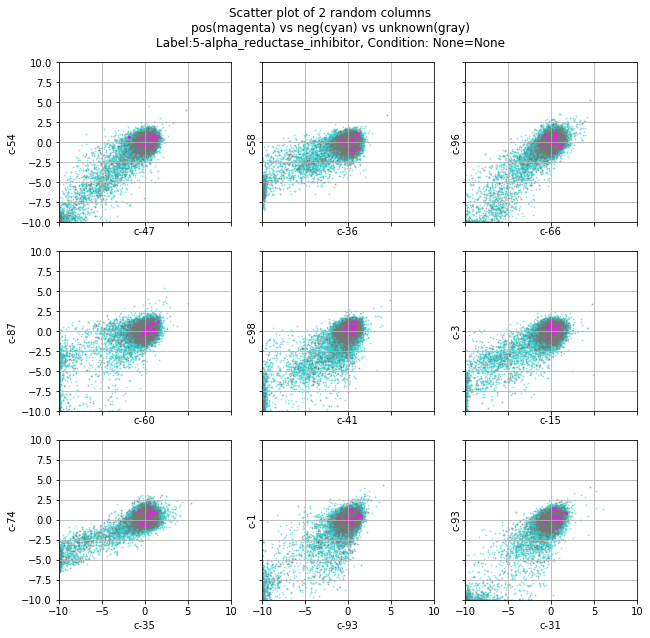

In [9]:
pos_neg_scatter(pos, neg, unk, c_feats, colname=None, colvalue=None, label=label)

すべてのラベルに対して陰性なものを探し出す

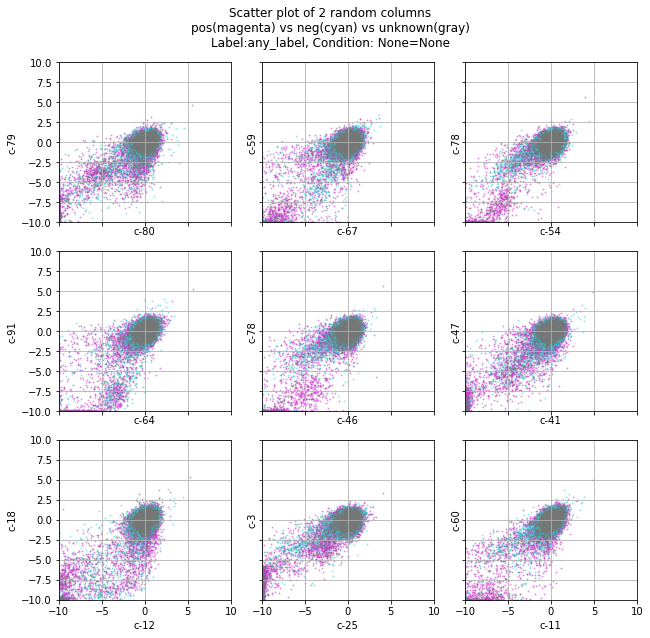

In [10]:
df['any_label'] = df[labels].sum(axis=1).apply(lambda x: np.sign(x)).astype(np.int8)
pos, neg, unk = split_by_label(df, 'any_label')
pos_neg_scatter(pos, neg, unk, c_feats, label='any_label', hide_positive=True)